In [1]:
import pandas as pd
import numpy as np
import joblib
import re
from google.colab import drive
import os

In [2]:
# Define paths
DATASET_PATH = '/content/drive/MyDrive/big_data_datasets/VimeWorld_prefinal.parquet/VimeWorld_prefinal.parquet'
MODEL_PATH = '/content/drive/MyDrive/big_data_datasets/best_models/best_random_forest.pkl'
OUTPUT_PATH = '/content/drive/MyDrive/big_data_datasets/predictions.csv'
PLOT_DIR = '/content/drive/MyDrive/big_data_datasets/plots/'

In [ ]:
# Feature extraction function (same as training script)
def extract_features(password):
    # Handle non-string passwords
    if not isinstance(password, str):
        password = str(password) if password is not None else ""

    features = {}
    features['length'] = len(password)
    features['has_letters'] = int(bool(re.search(r'[a-zA-Z]', password)))
    features['has_numbers'] = int(bool(re.search(r'\d', password)))
    features['has_special'] = int(bool(re.search(r'[^a-zA-Z\d]', password)))
    features['unique_chars'] = len(set(password)) / max(1, len(password))
    features['uppercase_count'] = sum(1 for c in password if c.isupper())
    features['lowercase_count'] = sum(1 for c in password if c.islower())
    features['number_count'] = sum(1 for c in password if c.isdigit())
    features['special_count'] = sum(1 for c in password if not c.isalnum())
    return features

In [ ]:
# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    try:
        # Read Parquet file
        df = pd.read_parquet(file_path)

        # Check for password_value column
        if 'password_value' not in df.columns:
            raise ValueError("Dataset does not contain 'password_value' column")

        # Filter out invalid passwords
        df = df.dropna(subset=['password_value'])
        df = df[df['password_value'].str.strip() != '']

        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

In [ ]:
# Prepare features for prediction
def prepare_features(df):
    # Extract features for each password
    features = df['password_value'].apply(extract_features)
    feature_df = pd.DataFrame(features.tolist())

    # Define expected feature columns (same as training)
    expected_columns = [
        'length', 'has_letters', 'has_numbers', 'has_special', 'unique_chars',
        'uppercase_count', 'lowercase_count', 'number_count', 'special_count'
    ]

    # Ensure all expected columns are present
    for col in expected_columns:
        if col not in feature_df.columns:
            feature_df[col] = 0

    # Reorder columns to match training
    feature_df = feature_df[expected_columns]

    return feature_df.values, expected_columns

In [ ]:
# Load model
def load_model(model_path):
    try:
        model = joblib.load(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [ ]:
# Predict password strengths
def predict_strengths(model, X, df):
    try:
        # Predict class (0, 1, 2)
        predictions = model.predict(X)

        # Predict probabilities
        probabilities = model.predict_proba(X)

        # Map predictions to labels
        strength_labels = {0: 'Weak', 1: 'Medium', 2: 'Strong'}
        predicted_labels = [strength_labels[pred] for pred in predictions]

        # Create results DataFrame with original columns
        results = df.copy()
        results['predicted_strength'] = predicted_labels
        results['prob_weak'] = probabilities[:, 0] * 100
        results['prob_medium'] = probabilities[:, 1] * 100
        results['prob_strong'] = probabilities[:, 2] * 100

        return results
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

In [ ]:
# Main execution
def main():
    # Load dataset
    df = load_and_preprocess_data(DATASET_PATH)
    if df is None:
        print("Failed to load dataset. Exiting.")
        return

    print(f"Loaded {len(df)} valid passwords")

    # Prepare features
    X, feature_columns = prepare_features(df)

    # Load model
    model = load_model(MODEL_PATH)
    if model is None:
        print("Failed to load model. Exiting.")
        return

    # Make predictions
    results = predict_strengths(model, X, df)
    if results is None:
        print("Failed to make predictions. Exiting.")
        return

    # Display sample results
    print("\nSample Predictions (first 10 rows):")
    print(results.head(10).to_string(index=False))

    # Save results to CSV
    try:
        os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
        results.to_csv(OUTPUT_PATH, index=False)
        print(f"\nPredictions saved to {OUTPUT_PATH}")
    except Exception as e:
        print(f"Error saving predictions: {e}")

    # Summary statistics
    print("\nPrediction Summary:")
    print(results['predicted_strength'].value_counts())

In [ ]:
if __name__ == "__main__":
    main()

Loaded 4103972 valid passwords
Model loaded successfully from /content/drive/MyDrive/big_data_datasets/best_models/best_random_forest.pkl

Sample Predictions (first 10 rows):
     username username_cc  username_len     password_value      password_mask password_cc  password_len predicted_strength  prob_weak  prob_medium  prob_strong
    123gogogo          dl             9           qwer1324           lllldddd          dl             8             Medium   0.000000   100.000000          0.0
  SonikkToYou          lu            11             qazzxc             llllll           l             6               Weak 100.000000     0.000000          0.0
 Neiron4ik_YT        dlsu            12           olgama23           lllllldd          dl             8             Medium   0.000000   100.000000          0.0
   SimonTV200         dlu            10         mix2002002         lllddddddd          dl            10             Medium   0.677397    99.322603          0.0
danilas31live          dl

In [ ]:
df_predicted = pd.read_csv(OUTPUT_PATH)

In [ ]:
len(df_predicted)

4103972

In [ ]:
df_predicted.head()

,username,username_cc,username_len,password_value,password_mask,password_cc,password_len,predicted_strength,prob_weak,prob_medium,prob_strong
0,123gogogo,dl,9,qwer1324,lllldddd,dl,8,Medium,0.000000,100.000000,0.0
1,SonikkToYou,lu,11,qazzxc,llllll,l,6,Weak,100.000000,0.000000,0.0
2,Neiron4ik_YT,dlsu,12,olgama23,lllllldd,dl,8,Medium,0.000000,100.000000,0.0
3,SimonTV200,dlu,10,mix2002002,lllddddddd,dl,10,Medium,0.677397,99.322603,0.0
4,danilas31live,dl,13,parolnet1,lllllllld,dl,9,Medium,0.000000,100.000000,0.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Create plot directory
os.makedirs(PLOT_DIR, exist_ok=True)

In [ ]:
# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    try:
        df = pd.read_csv(file_path)

        # Convert numeric columns
        numeric_cols = ['username_len', 'password_len', 'prob_weak', 'prob_medium', 'prob_strong']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Trim string columns
        string_cols = ['username', 'username_cc', 'password_value', 'password_mask', 'password_cc', 'predicted_strength']
        for col in string_cols:
            df[col] = df[col].str.strip()

        # Filter invalid rows
        df = df.dropna()
        df = df[df['predicted_strength'].isin(['Weak', 'Medium', 'Strong'])]
        df = df[(df['prob_weak'] >= 0) & (df['prob_medium'] >= 0) & (df['prob_strong'] >= 0)]

        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

In [ ]:
# Plot 1: Bar Plot of Predicted Strengths
def plot_strength_distribution(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='predicted_strength', palette='viridis', order=['Weak', 'Medium', 'Strong'])
    plt.title('Distribution of Predicted Password Strengths')
    plt.xlabel('Predicted Strength')
    plt.ylabel('Count')
    plt.savefig(os.path.join(PLOT_DIR, 'strength_distribution.png'))
    plt.show()

In [ ]:
# Plot 2: Histogram of Password Length by Strength
def plot_password_length_histogram(df):
    fig = px.histogram(df, x='password_len', color='predicted_strength', nbins=15,
                       title='Password Length Distribution by Strength',
                       labels={'password_len': 'Password Length', 'count': 'Count'},
                       color_discrete_map={'Weak': '#ef4444', 'Medium': '#3b82f6', 'Strong': '#10b981'})
    fig.update_layout(barmode='stack')
    fig.write_html(os.path.join(PLOT_DIR, 'password_length_histogram.html'))
    fig.show()

In [ ]:
# Plot 3: Pie Chart of Password Character Classes
def plot_password_cc_pie(df):
    cc_counts = df['password_cc'].value_counts().head(6)
    plt.figure(figsize=(8, 8))
    plt.pie(cc_counts, labels=cc_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', 6))
    plt.title('Top 6 Password Character Classes')
    plt.savefig(os.path.join(PLOT_DIR, 'password_cc_pie.png'))
    plt.show()

In [ ]:
# Plot 4: Scatter Plot of Password Length vs. Username Length
def plot_length_scatter(df):
    fig = px.scatter(df, x='username_len', y='password_len', color='predicted_strength',
                     title='Password Length vs. Username Length',
                     labels={'username_len': 'Username Length', 'password_len': 'Password Length'},
                     color_discrete_map={'Weak': '#ef4444', 'Medium': '#3b82f6', 'Strong': '#10b981'},
                     hover_data=['prob_weak', 'prob_medium', 'prob_strong'])
    fig.write_html(os.path.join(PLOT_DIR, 'length_scatter.html'))
    fig.show()

In [ ]:
# Plot 5: Box Plot of Probabilities by Strength
def plot_probability_box(df):
    fig = go.Figure()
    for strength in ['Weak', 'Medium', 'Strong']:
        subset = df[df['predicted_strength'] == strength]
        fig.add_trace(go.Box(y=subset['prob_weak'], name=f'{strength} - Weak', marker_color='#ef4444'))
        fig.add_trace(go.Box(y=subset['prob_medium'], name=f'{strength} - Medium', marker_color='#3b82f6'))
        fig.add_trace(go.Box(y=subset['prob_strong'], name=f'{strength} - Strong', marker_color='#10b981'))
    fig.update_layout(title='Probability Distributions by Predicted Strength',
                     yaxis_title='Probability (%)',
                     boxmode='group')
    fig.write_html(os.path.join(PLOT_DIR, 'probability_box.html'))
    fig.show()

In [ ]:
# Plot 6: Heatmap of Correlations
def plot_correlation_heatmap(df):
    corr = df[['username_len', 'password_len', 'prob_weak', 'prob_medium', 'prob_strong']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='viridis', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numeric Features')
    plt.savefig(os.path.join(PLOT_DIR, 'correlation_heatmap.png'))
    plt.show()

In [ ]:
# Plot 7: Violin Plot of Password Length by Strength
def plot_length_violin(df):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x='predicted_strength', y='password_len', palette='viridis',
                   order=['Weak', 'Medium', 'Strong'])
    plt.title('Password Length Distribution by Strength (Violin Plot)')
    plt.xlabel('Predicted Strength')
    plt.ylabel('Password Length')
    plt.savefig(os.path.join(PLOT_DIR, 'length_violin.png'))
    plt.show()

In [ ]:
# Plot 8: Stacked Bar Plot of Password Character Classes by Strength
def plot_cc_by_strength(df):
    cc_strength = df.groupby(['password_cc', 'predicted_strength']).size().unstack(fill_value=0)
    cc_strength = cc_strength.loc[cc_strength.sum(axis=1).nlargest(6).index]
    cc_strength.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ef4444', '#3b82f6', '#10b981'])
    plt.title('Top 6 Password Character Classes by Strength')
    plt.xlabel('Password Character Class')
    plt.ylabel('Count')
    plt.legend(title='Strength')
    plt.savefig(os.path.join(PLOT_DIR, 'cc_by_strength.png'))
    plt.show()

In [ ]:
# Plot 9: Area Plot of Cumulative Probabilities
def plot_cumulative_probabilities(df):
    sorted_df = df.sort_values('prob_strong', ascending=False).reset_index()
    plt.figure(figsize=(10, 6))
    plt.stackplot(sorted_df.index,
                  sorted_df['prob_weak'],
                  sorted_df['prob_medium'],
                  sorted_df['prob_strong'],
                  labels=['Weak', 'Medium', 'Strong'],
                  colors=['#ef4444', '#3b82f6', '#10b981'])
    plt.title('Cumulative Probability Distribution')
    plt.xlabel('Password Index (Sorted by Strong Probability)')
    plt.ylabel('Probability (%)')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(PLOT_DIR, 'cumulative_probabilities.png'))
    plt.show()

In [ ]:
# Plot 10: Count Plot of Username Character Classes
def plot_username_cc_count(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='username_cc', order=df['username_cc'].value_counts().index[:10], palette='viridis')
    plt.title('Top 10 Username Character Classes')
    plt.xlabel('Username Character Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(PLOT_DIR, 'username_cc_count.png'))
    plt.show()

In [ ]:
# Main execution
def main():
    # Load dataset
    df_predicted = load_and_preprocess_data(OUTPUT_PATH)
    if df_predicted is None:
        print("Failed to load dataset. Exiting.")
        return

    print(f"Loaded {len(df_predicted)} valid records")
    print("\nDataset Info:")
    print(df_predicted.info())
    print("\nSummary Statistics:")
    print(df_predicted.describe())

    # Generate plots
    print("\nGenerating visualizations...")
    plot_strength_distribution(df_predicted)
    plot_password_length_histogram(df_predicted)
    plot_password_cc_pie(df_predicted)
    plot_length_scatter(df_predicted)
    plot_probability_box(df_predicted)
    plot_correlation_heatmap(df_predicted)
    plot_length_violin(df_predicted)
    plot_cc_by_strength(df_predicted)
    plot_cumulative_probabilities(df_predicted)
    plot_username_cc_count(df_predicted)

Loaded 4103971 valid records

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4103971 entries, 0 to 4103971
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   username            object 
 1   username_cc         object 
 2   username_len        int64  
 3   password_value      object 
 4   password_mask       object 
 5   password_cc         object 
 6   password_len        int64  
 7   predicted_strength  object 
 8   prob_weak           float64
 9   prob_medium         float64
 10  prob_strong         float64
dtypes: float64(3), int64(2), object(6)
memory usage: 375.7+ MB
None

Summary Statistics:
       username_len  password_len     prob_weak   prob_medium   prob_strong
count  4.103971e+06  4.103971e+06  4.103971e+06  4.103971e+06  4.103971e+06
mean   9.707787e+00  9.319141e+00  4.534699e+01  5.431775e+01  3.352591e-01
std    2.808300e+00  2.551316e+00  4.912427e+01  4.903261e+01  4.514719e+00
min    3.000000e+00  1.00

<ipython-input-77-375d88fe78c0>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




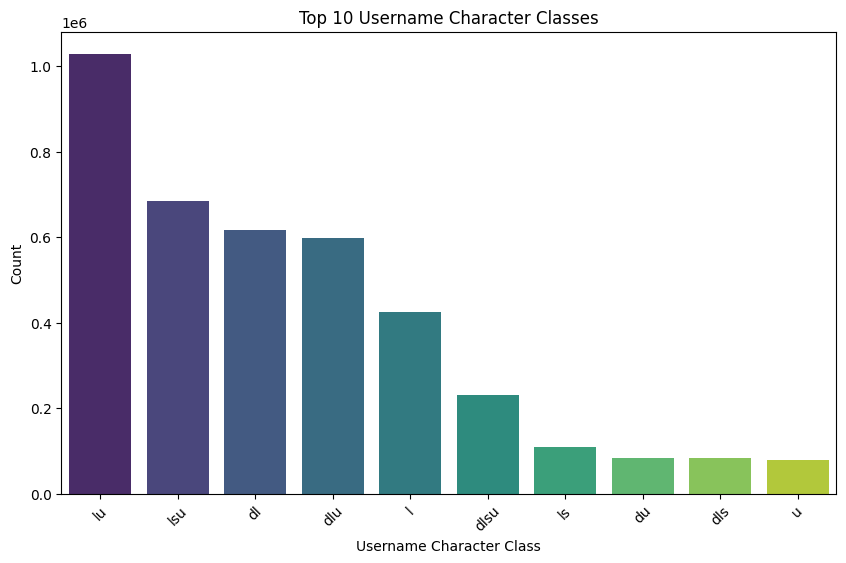

In [ ]:
if __name__ == "__main__":
    main()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("/content/drive/MyDrive/big_data_datasets/predictions.csv")

In [5]:
df.head()

,username,username_cc,username_len,password_value,password_mask,password_cc,password_len,predicted_strength,prob_weak,prob_medium,prob_strong
0,123gogogo,dl,9,qwer1324,lllldddd,dl,8,Medium,0.000000,100.000000,0.0
1,SonikkToYou,lu,11,qazzxc,llllll,l,6,Weak,100.000000,0.000000,0.0
2,Neiron4ik_YT,dlsu,12,olgama23,lllllldd,dl,8,Medium,0.000000,100.000000,0.0
3,SimonTV200,dlu,10,mix2002002,lllddddddd,dl,10,Medium,0.677397,99.322603,0.0
4,danilas31live,dl,13,parolnet1,lllllllld,dl,9,Medium,0.000000,100.000000,0.0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string

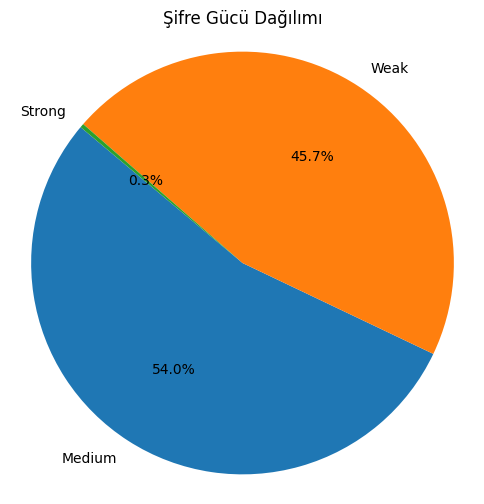

In [ ]:
import matplotlib.pyplot as plt

# Güç dağılımı
power_counts = df['predicted_strength'].value_counts()

# Pasta grafiği çiz
plt.figure(figsize=(6,6))
plt.pie(power_counts, labels=power_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Şifre Gücü Dağılımı")
plt.axis('equal')
plt.show()

<ipython-input-45-f0af3d1ea4ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_class_counts.index, y=char_class_counts.values, palette='Set2')


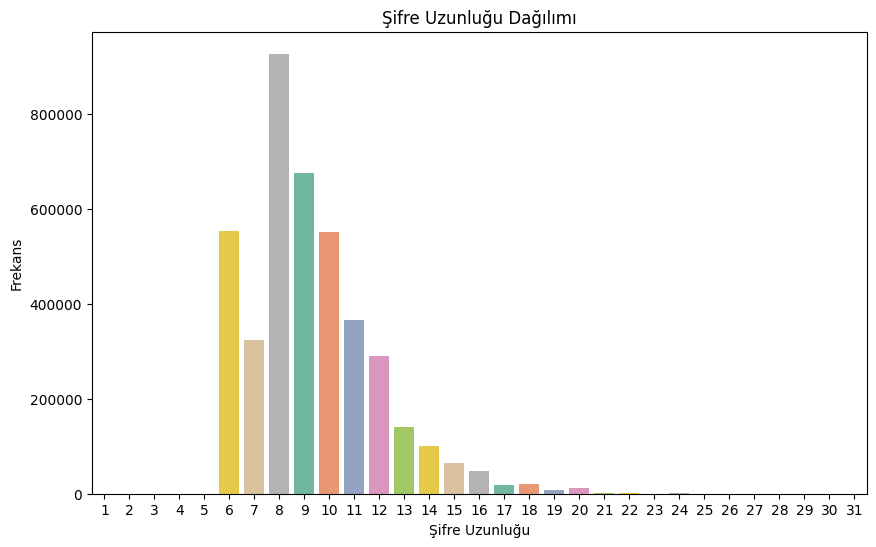

In [ ]:
char_class_counts = df['password_len'].value_counts()

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x=char_class_counts.index, y=char_class_counts.values, palette='Set2')
plt.title('Şifre Uzunluğu Dağılımı')
plt.xlabel('Şifre Uzunluğu')
plt.ylabel('Frekans')
plt.show()

<ipython-input-68-79dc7a42d2cb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_class_counts.index, y=char_class_counts.values, palette='Set2')


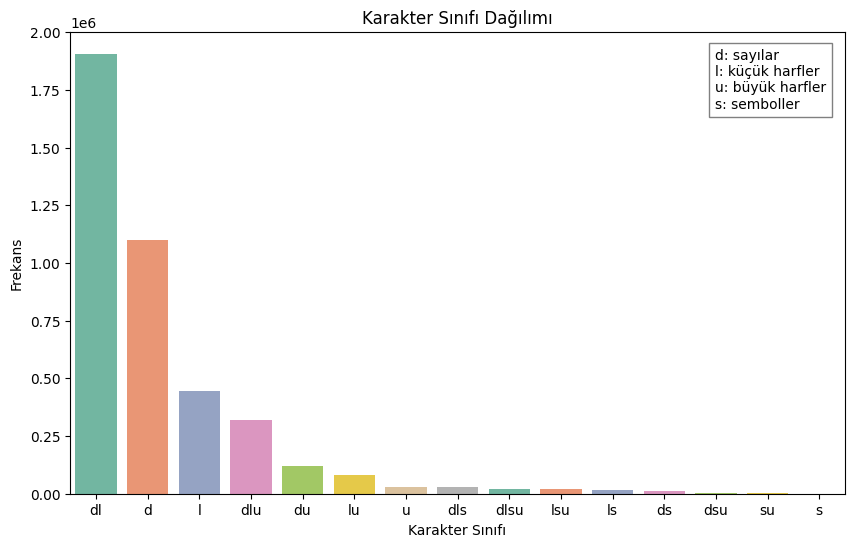

In [ ]:
char_class_counts = df['password_cc'].value_counts()

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x=char_class_counts.index, y=char_class_counts.values, palette='Set2')
plt.title('Karakter Sınıfı Dağılımı')
plt.xlabel('Karakter Sınıfı')
plt.ylabel('Frekans')
legend_text = (
    "d: sayılar\n"
    "l: küçük harfler\n"
    "u: büyük harfler\n"
    "s: semboller"
)

# Legend benzeri açıklama kutusu
plt.gcf().text(0.77, 0.80, legend_text, fontsize=10, va='center',
               bbox=dict(facecolor='white', edgecolor='gray'))
plt.show()

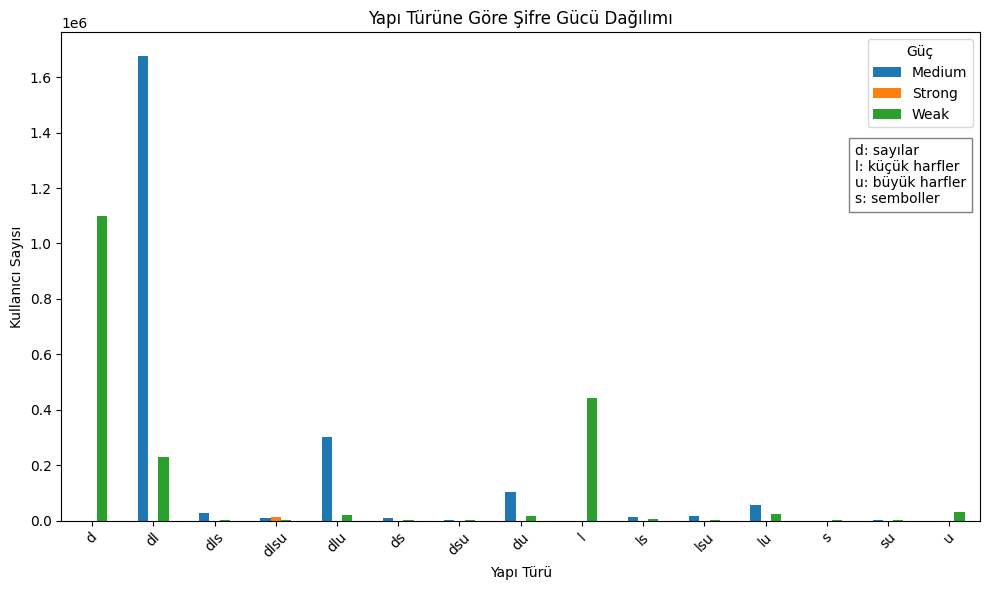

In [ ]:
# Gruplama
structure_power = df.groupby(['password_cc', 'predicted_strength']).size().unstack().fillna(0)

# Çubuk grafiği çiz
structure_power.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title("Yapı Türüne Göre Şifre Gücü Dağılımı")
plt.xlabel("Yapı Türü")
plt.ylabel("Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.legend(title="Güç")
legend_text = (
    "d: sayılar\n"
    "l: küçük harfler\n"
    "u: büyük harfler\n"
    "s: semboller"
)

# Legend benzeri açıklama kutusu
plt.gcf().text(0.86, 0.70, legend_text, fontsize=10, va='center',
               bbox=dict(facecolor='white', edgecolor='gray'))
plt.tight_layout()
plt.show()

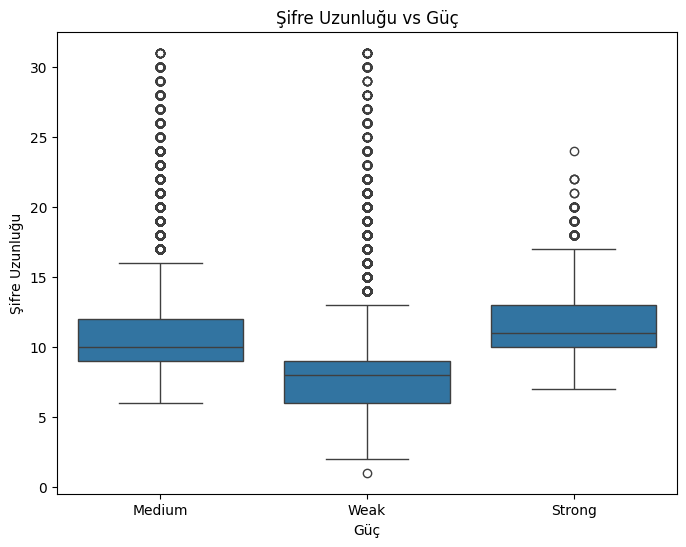

In [ ]:
# Boxplot çiz
plt.figure(figsize=(8,6))
sns.boxplot(x='predicted_strength', y='password_len', data=df)
plt.title("Şifre Uzunluğu vs Güç")
plt.xlabel("Güç")
plt.ylabel("Şifre Uzunluğu")
plt.show()

In [ ]:
# Tüm şifreleri birleştir
all_passwords = ''.join(df['password_value'].dropna().astype(str))

# Karakter frekanslarını say
char_counts = Counter(all_passwords)

# Ayır: harf, rakam, sembol
letters = {k: v for k, v in char_counts.items() if k.isalpha()}
digits = {k: v for k, v in char_counts.items() if k.isdigit()}
symbols = {k: v for k, v in char_counts.items() if not k.isalnum()}

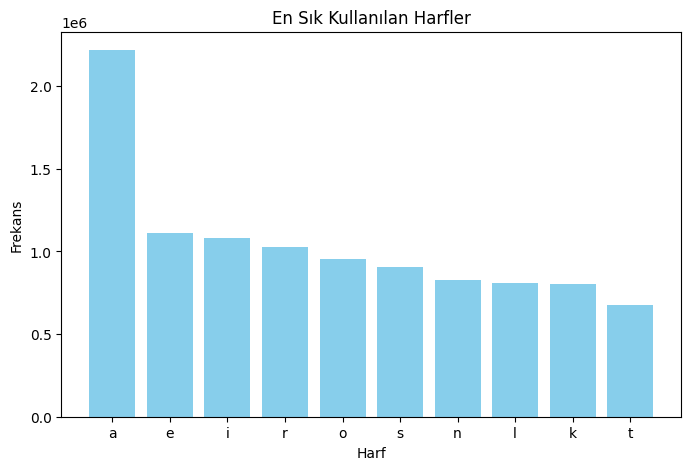

In [ ]:
# En çok kullanılan ilk 10 harf
top_letters = dict(sorted(letters.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(8,5))
plt.bar(top_letters.keys(), top_letters.values(), color='skyblue')
plt.title("En Sık Kullanılan Harfler")
plt.xlabel("Harf")
plt.ylabel("Frekans")
plt.show()

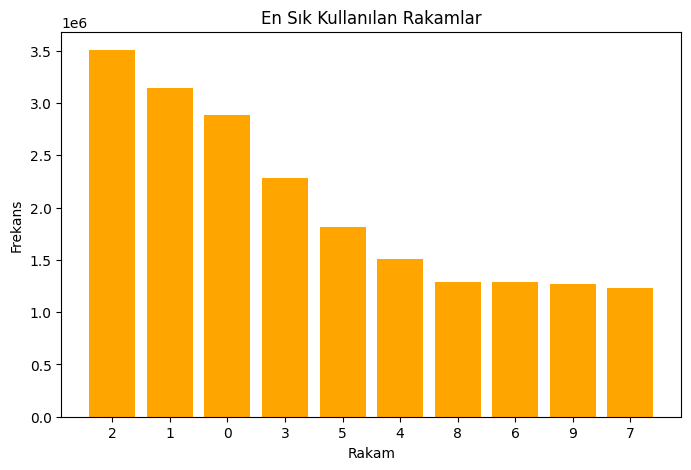

In [ ]:
# Tüm rakamlar için sıralama
sorted_digits = dict(sorted(digits.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8,5))
plt.bar(sorted_digits.keys(), sorted_digits.values(), color='orange')
plt.title("En Sık Kullanılan Rakamlar")
plt.xlabel("Rakam")
plt.ylabel("Frekans")
plt.show()

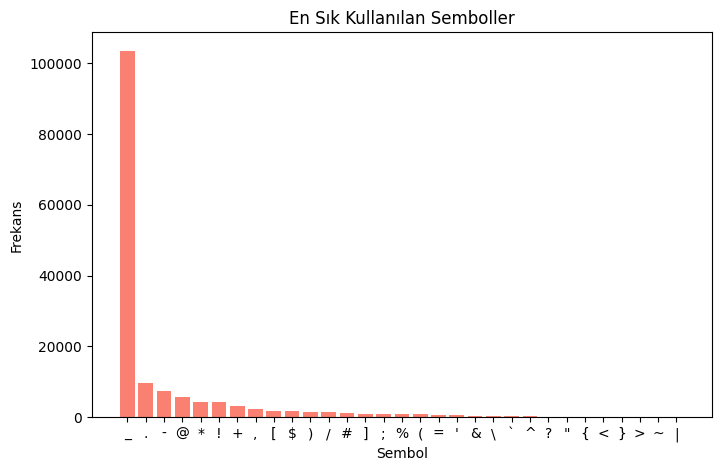

In [ ]:
# Semboller varsa çiz
if symbols:
    sorted_symbols = dict(sorted(symbols.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(8,5))
    plt.bar(sorted_symbols.keys(), sorted_symbols.values(), color='salmon')
    plt.title("En Sık Kullanılan Semboller")
    plt.xlabel("Sembol")
    plt.ylabel("Frekans")
    plt.show()
else:
    print("Hiç sembol bulunamadı.")

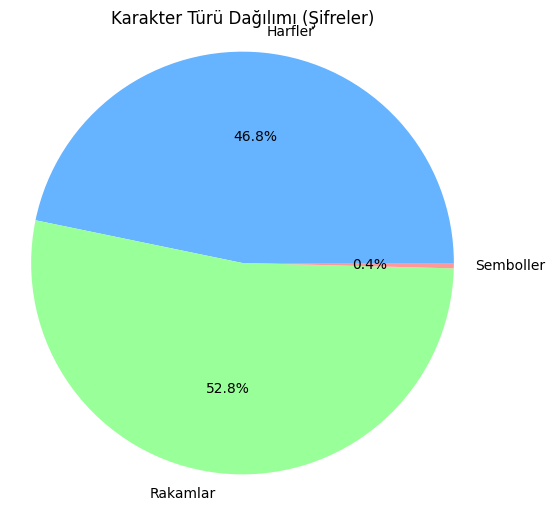

In [ ]:
# Genel karakter türü dağılımı
total_letters = sum(letters.values())
total_digits = sum(digits.values())
total_symbols = sum(symbols.values())

plt.figure(figsize=(6,6))
plt.pie(
    [total_letters, total_digits, total_symbols],
    labels=['Harfler', 'Rakamlar', 'Semboller'],
    autopct='%1.1f%%',
    colors=['#66b3ff','#99ff99','#ff9999']
)
plt.title("Karakter Türü Dağılımı (Şifreler)")
plt.axis('equal')
plt.show()

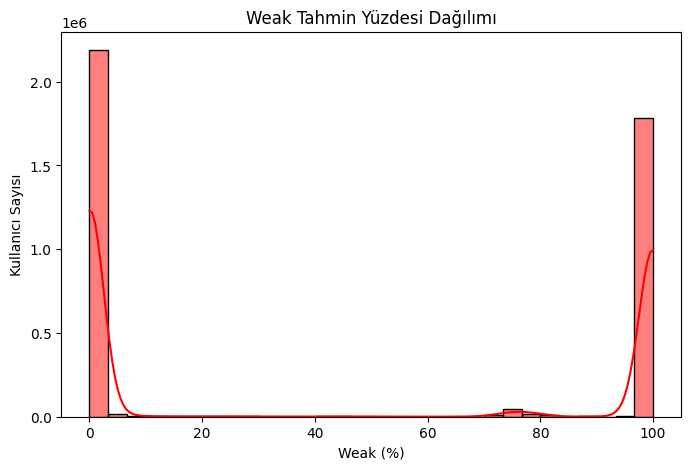

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['prob_weak'], kde=True, color='red', bins=30)
plt.title("Weak Tahmin Yüzdesi Dağılımı")
plt.xlabel("Weak (%)")
plt.ylabel("Kullanıcı Sayısı")
plt.show()

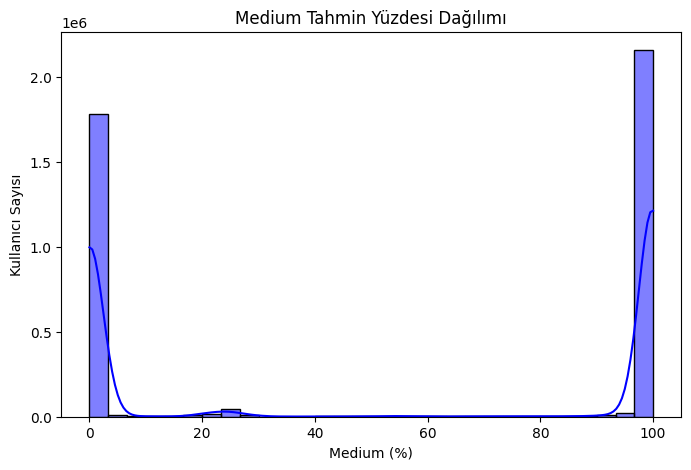

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['prob_medium'], kde=True, color='blue', bins=30)
plt.title("Medium Tahmin Yüzdesi Dağılımı")
plt.xlabel("Medium (%)")
plt.ylabel("Kullanıcı Sayısı")
plt.show()

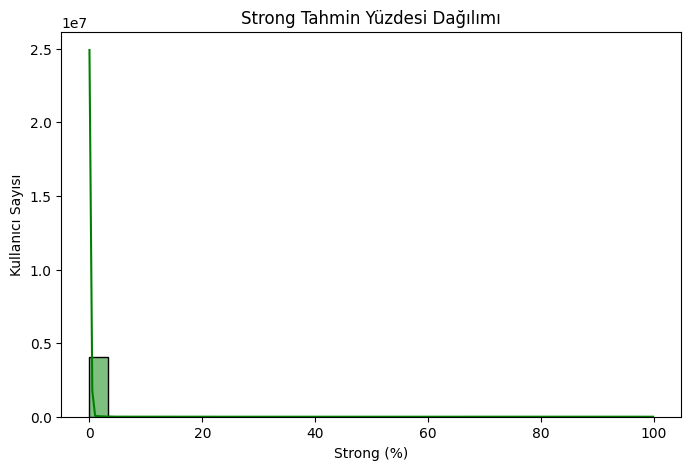

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['prob_strong'], kde=True, color='green', bins=30)
plt.title("Strong Tahmin Yüzdesi Dağılımı")
plt.xlabel("Strong (%)")
plt.ylabel("Kullanıcı Sayısı")
plt.show()

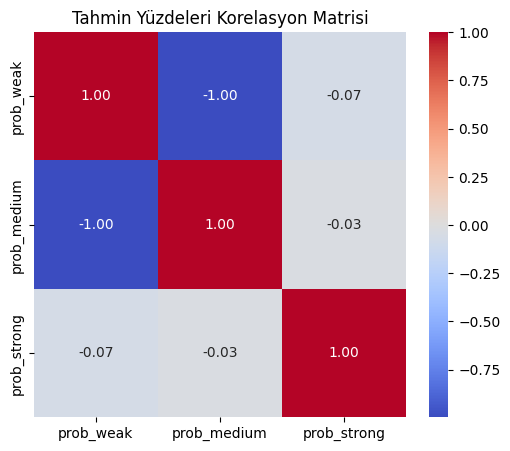

In [ ]:
# Tahmin sütunlarını seç
pred_cols = ['prob_weak', 'prob_medium', 'prob_strong']
corr = df[pred_cols].corr()

# Isı haritası
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Tahmin Yüzdeleri Korelasyon Matrisi")
plt.show()

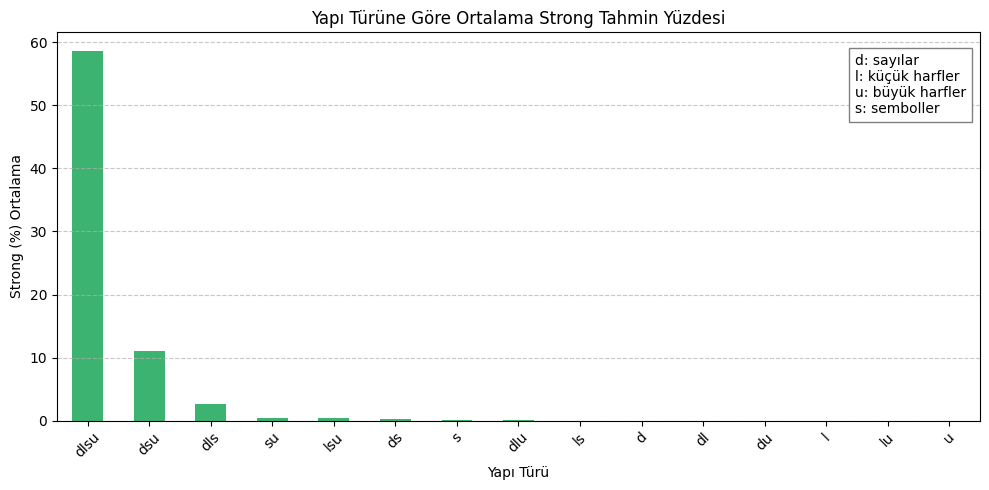

In [ ]:
# Yapı türüne göre strong yüzdesi ortalaması
avg_strong_by_structure = df.groupby('password_cc')['prob_strong'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
avg_strong_by_structure.plot(kind='bar', color='mediumseagreen')
plt.title("Yapı Türüne Göre Ortalama Strong Tahmin Yüzdesi")
plt.xlabel("Yapı Türü")
plt.ylabel("Strong (%) Ortalama")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Sadece temel karakter türlerini göster
legend_text = (
    "d: sayılar\n"
    "l: küçük harfler\n"
    "u: büyük harfler\n"
    "s: semboller"
)

# Legend benzeri açıklama kutusu
plt.gcf().text(0.86, 0.82, legend_text, fontsize=10, va='center',
               bbox=dict(facecolor='white', edgecolor='gray'))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


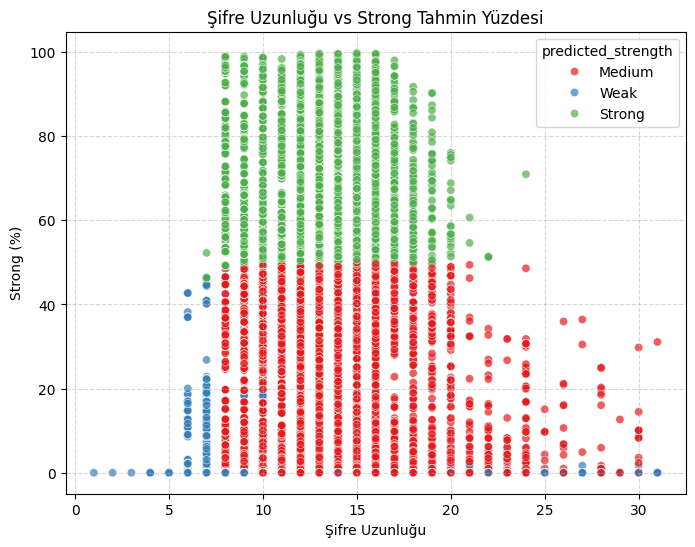

In [ ]:
# Scatter plot: uzunluk vs strong yüzdesi
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='password_len', y='prob_strong', hue='predicted_strength', palette='Set1', alpha=0.7)
plt.title("Şifre Uzunluğu vs Strong Tahmin Yüzdesi")
plt.xlabel("Şifre Uzunluğu")
plt.ylabel("Strong (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

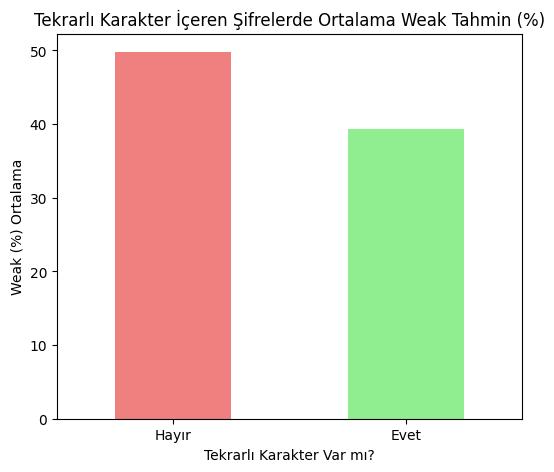

In [8]:
# Tekrarlı karakter içeren şifreleri kontrol et (örneğin aynı harf ardışık 2+ kez geçiyorsa)
import re

def has_repeated_chars(pwd):
    return bool(re.search(r'(.)\1{1,}', str(pwd)))  # Aynı karakterden en az 2 kez ardışık

df['is_repeated'] = df['password_value'].apply(has_repeated_chars)

# Tekrarlılara göre strong tahmin ortalaması
repeat_analysis = df.groupby('is_repeated')['prob_weak'].mean()

plt.figure(figsize=(6,5))
repeat_analysis.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title("Tekrarlı Karakter İçeren Şifrelerde Ortalama Weak Tahmin (%)")
plt.xlabel("Tekrarlı Karakter Var mı?")
plt.ylabel("Weak (%) Ortalama")
plt.xticks([0, 1], ['Hayır', 'Evet'], rotation=0)
plt.show()

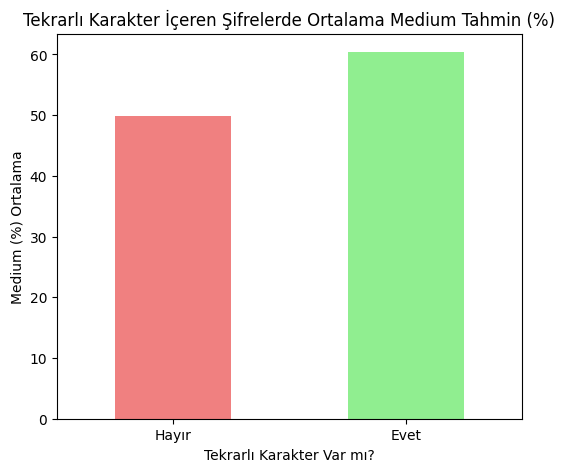

In [7]:
# Tekrarlı karakter içeren şifreleri kontrol et (örneğin aynı harf ardışık 2+ kez geçiyorsa)
import re

def has_repeated_chars(pwd):
    return bool(re.search(r'(.)\1{1,}', str(pwd)))  # Aynı karakterden en az 2 kez ardışık

df['is_repeated'] = df['password_value'].apply(has_repeated_chars)

# Tekrarlılara göre strong tahmin ortalaması
repeat_analysis = df.groupby('is_repeated')['prob_medium'].mean()

plt.figure(figsize=(6,5))
repeat_analysis.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title("Tekrarlı Karakter İçeren Şifrelerde Ortalama Medium Tahmin (%)")
plt.xlabel("Tekrarlı Karakter Var mı?")
plt.ylabel("Medium (%) Ortalama")
plt.xticks([0, 1], ['Hayır', 'Evet'], rotation=0)
plt.show()

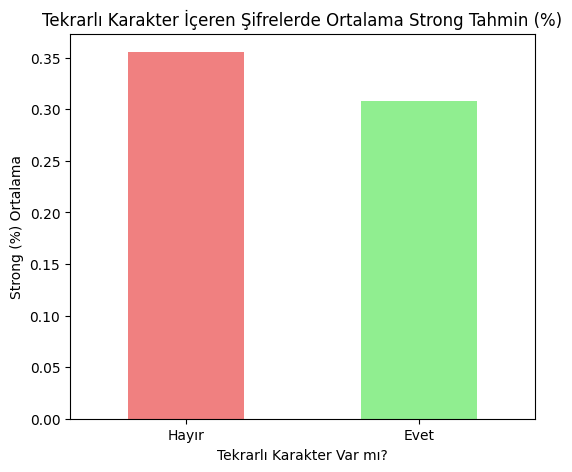

In [ ]:
# Tekrarlı karakter içeren şifreleri kontrol et (örneğin aynı harf ardışık 2+ kez geçiyorsa)
import re

def has_repeated_chars(pwd):
    return bool(re.search(r'(.)\1{1,}', str(pwd)))  # Aynı karakterden en az 2 kez ardışık

df['is_repeated'] = df['password_value'].apply(has_repeated_chars)

# Tekrarlılara göre strong tahmin ortalaması
repeat_analysis = df.groupby('is_repeated')['prob_strong'].mean()

plt.figure(figsize=(6,5))
repeat_analysis.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title("Tekrarlı Karakter İçeren Şifrelerde Ortalama Strong Tahmin (%)")
plt.xlabel("Tekrarlı Karakter Var mı?")
plt.ylabel("Strong (%) Ortalama")
plt.xticks([0, 1], ['Hayır', 'Evet'], rotation=0)
plt.show()

<ipython-input-73-a6c7b744d963>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='predicted_strength', y='password_len', data=df, palette='pastel')


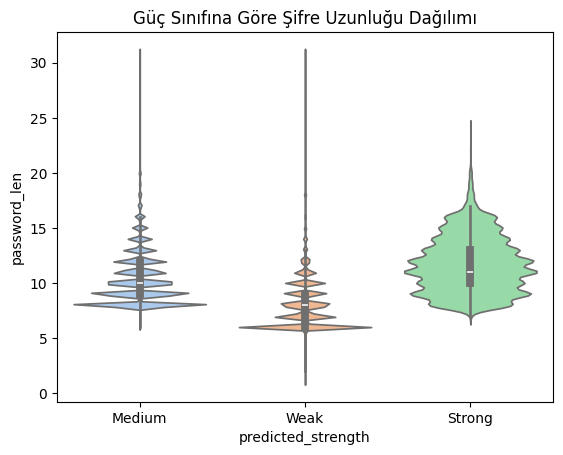

In [ ]:
sns.violinplot(x='predicted_strength', y='password_len', data=df, palette='pastel')
plt.title("Güç Sınıfına Göre Şifre Uzunluğu Dağılımı")
plt.show()

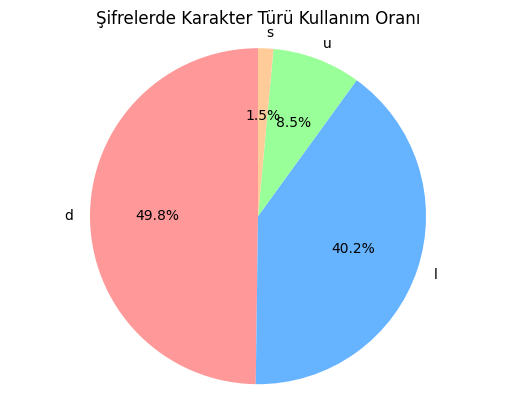

In [ ]:
types = ['d', 'l', 'u', 's']
type_counts = {t: df['password_cc'].str.contains(t).sum() for t in types}

plt.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title("Şifrelerde Karakter Türü Kullanım Oranı")
plt.axis('equal')
plt.show()

In [ ]:
patterns = {
    "123": r"123",
    "abc": r"abc",
    "qwe": r"qwe",
    "111": r"(1{3,})",
    "000": r"(0{3,})",
    "password": r"password",
    "admin": r"admin",
    "qwerty": r"qwerty",
    "iloveyou": r"iloveyou",
    "letmein": r"letmein",
    "birth_year": r"(19[0-9]{2}|20[0-2][0-9])"  # 1900–2029 arası
}

import pandas as pd
import re

# Sonuçları tutmak için liste
pattern_stats = []

# Her kalıp için kontrol ve sınıf dağılımı
for name, regex in patterns.items():
    matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]
    count = len(matched)
    strength_dist = matched['predicted_strength'].value_counts().reindex(['Weak', 'Medium', 'Strong'], fill_value=0)
    pattern_stats.append({
        'pattern': name,
        'total_count': count,
        'weak': strength_dist['Weak'],
        'medium': strength_dist['Medium'],
        'strong': strength_dist['Strong']
    })

# Tabloya dök
pattern_df = pd.DataFrame(pattern_stats)
pattern_df = pattern_df.sort_values(by='total_count', ascending=False)
pattern_df

<ipython-input-76-7008eb70fbbf>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]
<ipython-input-76-7008eb70fbbf>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]
<ipython-input-76-7008eb70fbbf>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]


,pattern,total_count,weak,medium,strong
0,123,785704,383615,400406,1683
10,birth_year,741438,226362,513427,1649
2,qwe,116272,36337,79747,188
3,111,45447,25275,20139,33
7,qwerty,42711,13227,29380,104
4,000,42154,17669,24439,46
1,abc,2566,499,2064,3
6,admin,2236,482,1731,23
5,password,1431,576,842,13
8,iloveyou,325,162,163,0


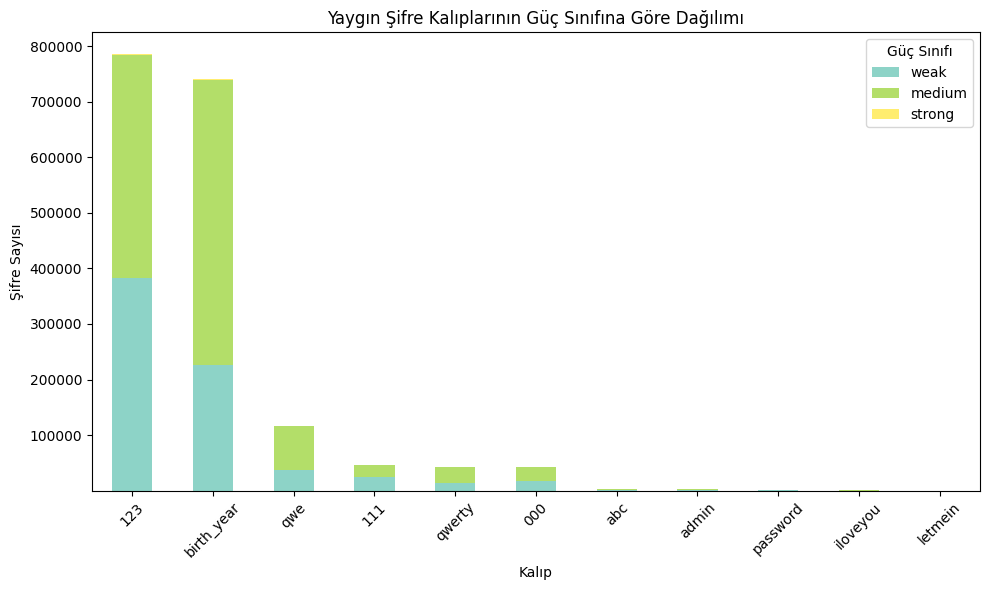

In [ ]:
pattern_df.set_index('pattern')[['weak', 'medium', 'strong']].plot(
    kind='bar',
    stacked=True,
    colormap='Set3',
    figsize=(10, 6)
)

plt.title("Yaygın Şifre Kalıplarının Güç Sınıfına Göre Dağılımı")
plt.xlabel("Kalıp")
plt.ylabel("Şifre Sayısı")
plt.xticks(rotation=45)
plt.legend(title='Güç Sınıfı')
plt.tight_layout()
plt.show()

In [ ]:
# İlk 3 en çok kullanılan pattern
top3_patterns = pattern_df.head(3)['pattern'].tolist()

for pattern in top3_patterns:
    regex = patterns[pattern]
    matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]
    print(f"\n🔎 Kalıp: {pattern} | Eşleşen Şifre Sayısı: {len(matched)}")
    print(matched[['username', 'password_value', 'predicted_strength']].head(5).to_string(index=False))


🔎 Kalıp: 123 | Eşleşen Şifre Sayısı: 785704
        username  password_value predicted_strength
          Dedzed 123456789101112               Weak
     Murzilka123       polaki123             Medium
MarshmelloGaming    glebkonev123             Medium
     Nazar_12376    123maksum123             Medium
      danilUA123      qwerty1234             Medium


<ipython-input-81-e281376477a9>:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched = df[df['password_value'].str.contains(regex, case=False, regex=True)]



🔎 Kalıp: birth_year | Eşleşen Şifre Sayısı: 741438
    username password_value predicted_strength
  SimonTV200     mix2002002             Medium
    Sinriese       05062002               Weak
      228328       13121973               Weak
   chudiklol    dfcbktr2010             Medium
WTFOHHMANPVP     kostia2006             Medium

🔎 Kalıp: qwe | Eşleşen Şifre Sayısı: 116272
     username password_value predicted_strength
    123gogogo       qwer1324             Medium
   danilUA123     qwerty1234             Medium
      _lev_04       qazqwe21             Medium
natanel123456   zxcasd123qwe             Medium
       kjk103         123qwe               Weak


<ipython-input-83-f49bc1b57d8d>:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  birth_year_matches = df[df['password_value'].str.contains(birth_year_regex, regex=True)]
<ipython-input-83-f49bc1b57d8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birth_year_matches['birth_year'] = birth_year_matches['password_value'].str.extract(r'(19[0-9]{2}|20[0-2][0-9])')


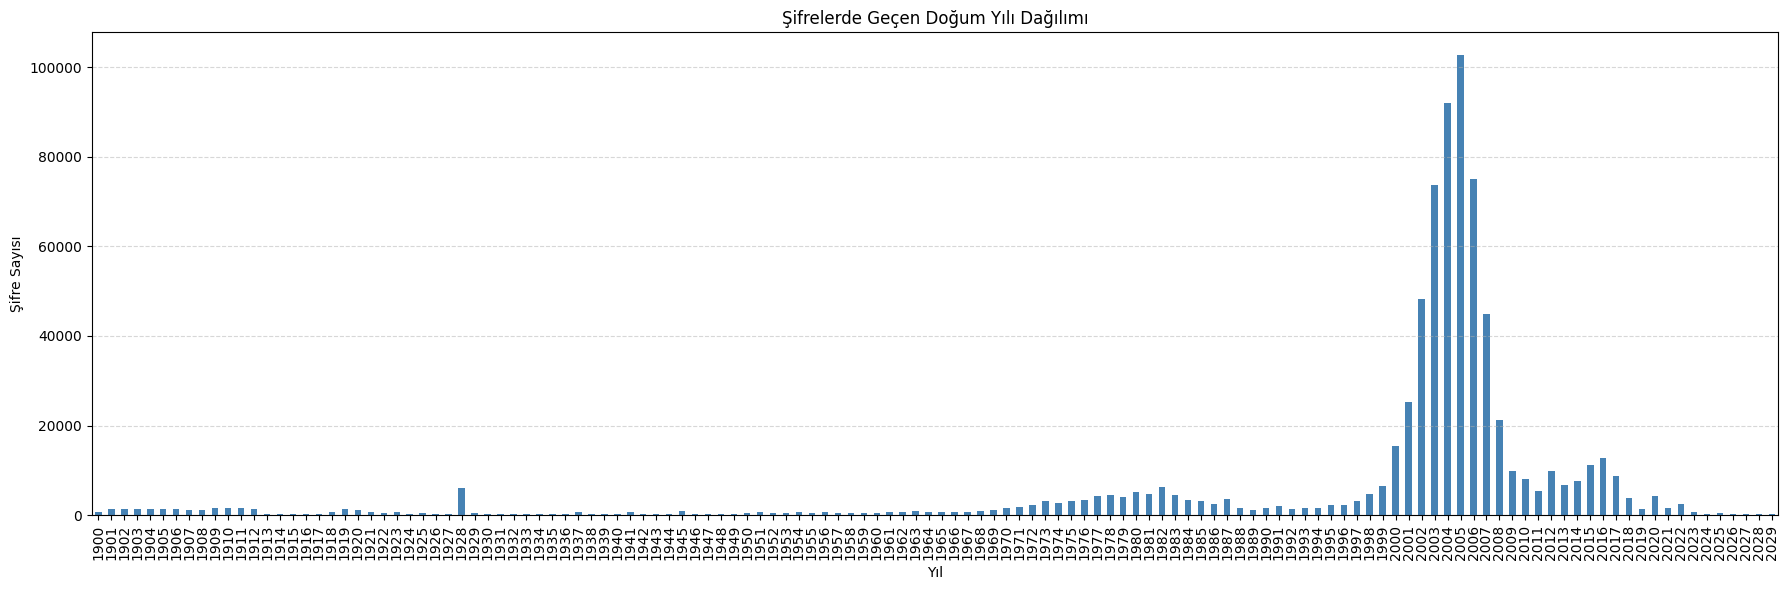

In [ ]:
# Doğum yılı içeren şifreleri filtrele
birth_year_regex = patterns["birth_year"]
birth_year_matches = df[df['password_value'].str.contains(birth_year_regex, regex=True)]

# Şifre içindeki yılı çıkartmak için regex
birth_year_matches['birth_year'] = birth_year_matches['password_value'].str.extract(r'(19[0-9]{2}|20[0-2][0-9])')

# Yıla göre dağılımı çiz 1900-2029
plt.figure(figsize=(18,6))
birth_year_matches['birth_year'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title("Şifrelerde Geçen Doğum Yılı Dağılımı")
plt.xlabel("Yıl")
plt.ylabel("Şifre Sayısı")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

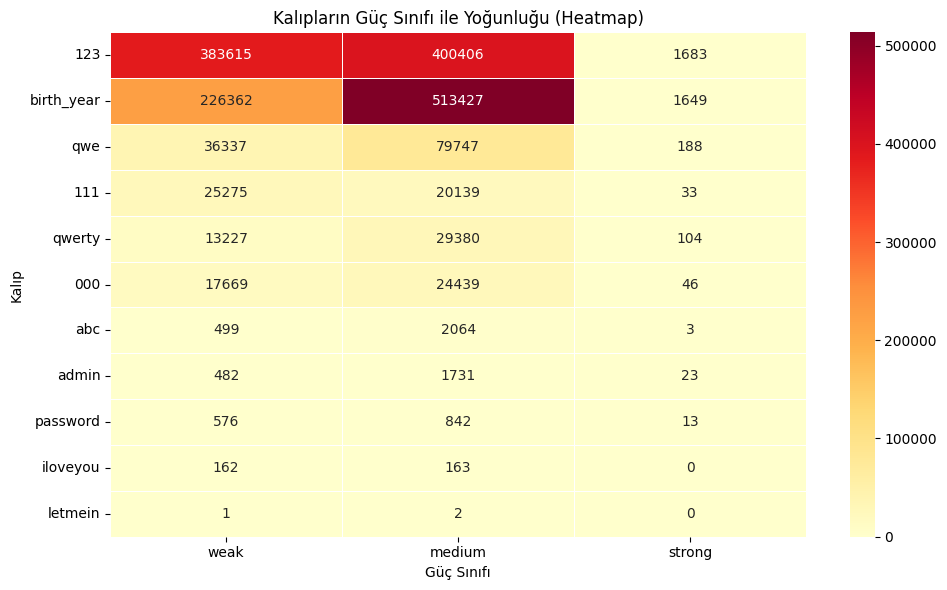

In [ ]:
import seaborn as sns

# Heatmap verisi
heatmap_data = pattern_df.set_index('pattern')[['weak', 'medium', 'strong']]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', linewidths=.5)
plt.title("Kalıpların Güç Sınıfı ile Yoğunluğu (Heatmap)")
plt.xlabel("Güç Sınıfı")
plt.ylabel("Kalıp")
plt.tight_layout()
plt.show()